In [ ]:
import os
import librosa
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from google.colab import drive
drive.mount('/content/drive')
dataset_dir = '/content/drive/MyDrive/Capstone Project ML/donateacry_corpus_cleaned_and_updated_data/'

# Inisialisasi list untuk menyimpan fitur audio dan label
audio_features = []
labels = []

# Menentukan panjang maksimum fitur (jumlah frame MFCC)
max_length = 10000  # Sesuaikan panjang sesuai kebutuhan Anda

# Melakukan iterasi pada setiap folder (kategori)
for category in os.listdir(dataset_dir):
    category_dir = os.path.join(dataset_dir, category)
    for filename in os.listdir(category_dir):
        if filename.endswith(".wav"):
            filepath = os.path.join(category_dir, filename)
            # Membaca file audio
            audio, sr = librosa.load(filepath, sr=None)  # sr=None agar sampling rate asli digunakan
            # Ekstraksi fitur audio (misalnya, MFCC)
            mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
            # Zero-padding untuk menyamakan panjang fitur
            if mfccs.shape[1] < max_length:
                pad_width = max_length - mfccs.shape[1]
                mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
            else:
                mfccs = mfccs[:, :max_length]
            # Menyimpan fitur dan label
            audio_features.append(mfccs)
            labels.append(category)

# Konversi label ke angka
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Split data menjadi data pelatihan dan pengujian
X_train, X_test, y_train, y_test = train_test_split(audio_features, labels, test_size=0.2, random_state=42)

# Konversi data ke bentuk array NumPy
X_train = np.array(X_train)
X_test = np.array(X_test)

# Membangun model RNN dengan LSTM
model = keras.Sequential([
    layers.LSTM(512, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dropout(0.3),
    layers.Dense(len(label_encoder.classes_), activation='softmax')
])

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('val_accuracy') >= 0.90):
            print("\nReached 91% accuracy so cancelling training!")
            self.model.stop_training = True

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

callbacks = myCallback()
# Latih model
history = model.fit(
    X_train,  # Input data for training
    y_train,  # Target data for training
    epochs=100,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks = [callbacks]# Validation data
)

# Evaluasi model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/100
26/26 [==============================] - 5s 113ms/step - loss: 2.5422 - accuracy: 0.6016 - val_loss: 1.0420 - val_accuracy: 0.7946
Epoch 2/100
26/26 [==============================] - 2s 69ms/step - loss: 0.9295 - accuracy: 0.8309 - val_loss: 0.8288 - val_accuracy: 0.8688
Epoch 3/100
26/26 [==============================] - 2s 68ms/step - loss: 0.7943 - accuracy: 0.8742 - val_loss: 0.7509 - val_accuracy: 0.8366
Epoch 4/100
26/26 [==============================] - 2s 68ms/step - loss: 0.7570 - accuracy: 0.8866 - val_loss: 0.6676 - val_accuracy: 0.8738
Epoch 5/100
26/26 [==============================] - 2s 66ms/step - loss: 0.7149 - accuracy: 0.8916 - val_loss: 0.6701 - val_accuracy: 0.8837
Epoch 6/100
26/26 [==============================] - 2s 66ms/step - loss: 0.7611 - accuracy: 0.8804 - val_loss: 0.7183 - val_accuracy: 0.8762
Epoch 7/100
26/26 

In [ ]:
print("Number of training samples (X_train):", X_train.shape[0])
print("Number of training labels (y_train):", len(y_train))
print("Number of test samples (X_test):", X_test.shape[0])
print("Number of test labels (y_test):", len(y_test))

Number of training samples (X_train): 1614
Number of training labels (y_train): 1614
Number of test samples (X_test): 404
Number of test labels (y_test): 404


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 13, 512)           21530624  
                                                                 
 batch_normalization_1 (Bat  (None, 13, 512)           2048      
 chNormalization)                                                
                                                                 
 dropout_2 (Dropout)         (None, 13, 512)           0         
                                                                 
 flatten_1 (Flatten)         (None, 6656)              0         
                                                                 
 dropout_3 (Dropout)         (None, 6656)              0         
                                                                 
 dense_1 (Dense)             (None, 5)                 33285     
                                                      

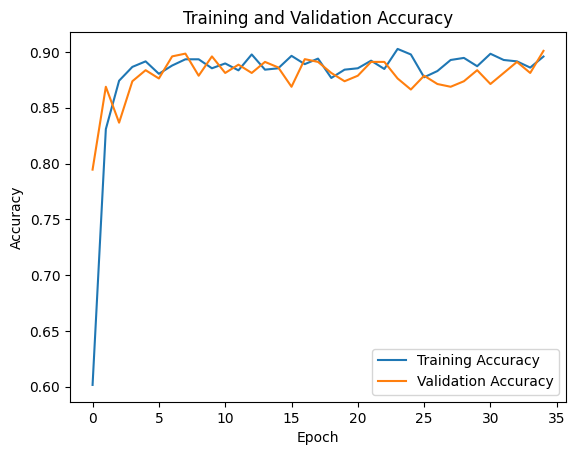

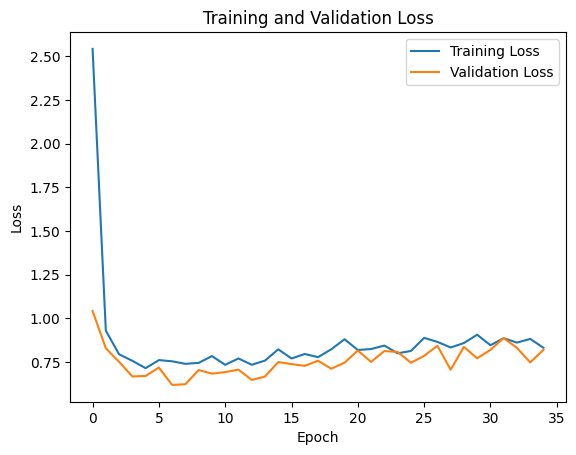

In [ ]:
import matplotlib.pyplot as plt

# Plot training history (accuracy and loss)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/Capstone Project ML/babycryfix.h5')

In [ ]:
# Make predictions on the test set
predictions = model.predict(X_test)

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Convert numeric labels back to original labels using the label encoder
predicted_category_labels = label_encoder.inverse_transform(predicted_labels)

# Display some predictions
for i in range(10):  # Display predictions for the first 10 samples
    print(f"True Label: {label_encoder.classes_[y_test[i]]}, Predicted Label: {predicted_category_labels[i]}")

13/13 [==============================] - 1s 23ms/step
True Label: tired, Predicted Label: tired
True Label: hungry, Predicted Label: hungry
True Label: hungry, Predicted Label: hungry
True Label: belly_pain, Predicted Label: belly_pain
True Label: hungry, Predicted Label: hungry
True Label: burping, Predicted Label: tired
True Label: burping, Predicted Label: burping
True Label: hungry, Predicted Label: hungry
True Label: belly_pain, Predicted Label: belly_pain
True Label: hungry, Predicted Label: hungry
